In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import os
from transformers import trainer, TrainingArguments

# ==========================
# 1. Reproducibility
# ==========================
SEED = 4213
np.random.seed(SEED)
torch.manual_seed(SEED)

# ==========================
# 2. Load and prepare dataset
# ==========================
df = pd.read_csv("../combine_data_clean.csv")
df = df[["text", "is_sarcastic"]].dropna()
df["is_sarcastic"] = df["is_sarcastic"].astype(int)
df = df.rename(columns={"is_sarcastic": "label"})

# --- same 80/10/10 split as training ---
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df["label"])

print(f"Loaded dataset -> Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# ==========================
# 3. Tokenization
# ==========================
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

test_ds = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Loaded dataset -> Train: 178118 | Val: 22265 | Test: 22265


Map:   0%|          | 0/22265 [00:00<?, ? examples/s]

In [ ]:
# Load fine-tuned model

from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
state_dict = torch.load("best_full_finetuned_distilbert.pt", map_location="cpu")
model.load_state_dict(state_dict)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
# Create sentiment-masked test set

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

analyzer = SentimentIntensityAnalyzer()

def neutralize_sentiment_words(text, threshold=0.5):
    tokens = text.split()
    masked_tokens = []
    for t in tokens:
        # Remove punctuation for analysis
        clean_t = re.sub(r'[^\w\s]', '', t)
        if clean_t == "":
            masked_tokens.append(t)
            continue
        score = analyzer.polarity_scores(clean_t)["compound"]
        # Mask strongly positive or negative words
        if abs(score) >= threshold:
            masked_tokens.append("NEUTRAL")
        else:
            masked_tokens.append(t)
    return " ".join(masked_tokens)

In [ ]:
# Run ablation for multiple thresholds

thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

trainer = Trainer(model=model)
preds_orig = trainer.predict(test_ds)
y_true = np.array(test_df["label"])
y_pred_orig = np.argmax(preds_orig.predictions, axis=1)
f1_baseline = f1_score(y_true, y_pred_orig)
print(f"Baseline F1: {f1_baseline:.4f}")

for THRESHOLD in thresholds:
    print(f"\n=== Evaluating with threshold = {THRESHOLD} ===")

    # Mask sentiment words
    test_df_masked = test_df.copy()
    test_df_masked["text"] = test_df_masked["text"].apply(
        lambda x: neutralize_sentiment_words(x, threshold=THRESHOLD)
    )

    # Quick example check
    print("\n--- Example before/after masking ---")
    for i in range(1):
        print(f"Original: {test_df.iloc[i]['text']}")
        print(f"Masked  : {test_df_masked.iloc[i]['text']}")

    # Tokenize masked dataset
    masked_ds = Dataset.from_pandas(test_df_masked).map(tokenize_function, batched=True)
    masked_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    # Predict on masked dataset
    preds_masked = trainer.predict(masked_ds)
    y_pred_masked = np.argmax(preds_masked.predictions, axis=1)

    # Compute F1 and delta
    f1_masked = f1_score(y_true, y_pred_masked)
    delta = f1_masked - f1_baseline
    print(f"Masked F1 ({THRESHOLD}): {f1_masked:.4f}")
    print(f"ΔF1 ({THRESHOLD}): {delta:+.4f}")

print("\n✅ Sentiment masking ablation complete.")

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Baseline F1: 0.8684

=== Evaluating with threshold = 0.1 ===

--- Example before/after masking ---
Original: please, there is no such thing as "white privilege", they worked hard for it and deserve their wealth.
Masked  : NEUTRAL there is NEUTRAL such thing as "white NEUTRAL they worked NEUTRAL for it and deserve their NEUTRAL


Map:   0%|          | 0/22265 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Masked F1 (0.1): 0.8233
ΔF1 (0.1): -0.0451

=== Evaluating with threshold = 0.3 ===

--- Example before/after masking ---
Original: please, there is no such thing as "white privilege", they worked hard for it and deserve their wealth.
Masked  : NEUTRAL there is no such thing as "white NEUTRAL they worked hard for it and deserve their NEUTRAL


Map:   0%|          | 0/22265 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Masked F1 (0.3): 0.8392
ΔF1 (0.3): -0.0292

=== Evaluating with threshold = 0.5 ===

--- Example before/after masking ---
Original: please, there is no such thing as "white privilege", they worked hard for it and deserve their wealth.
Masked  : please, there is no such thing as "white privilege", they worked hard for it and deserve their wealth.


Map:   0%|          | 0/22265 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Masked F1 (0.5): 0.8506
ΔF1 (0.5): -0.0178

=== Evaluating with threshold = 0.7 ===

--- Example before/after masking ---
Original: please, there is no such thing as "white privilege", they worked hard for it and deserve their wealth.
Masked  : please, there is no such thing as "white privilege", they worked hard for it and deserve their wealth.


Map:   0%|          | 0/22265 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Masked F1 (0.7): 0.8684
ΔF1 (0.7): +0.0000

=== Evaluating with threshold = 0.9 ===

--- Example before/after masking ---
Original: please, there is no such thing as "white privilege", they worked hard for it and deserve their wealth.
Masked  : please, there is no such thing as "white privilege", they worked hard for it and deserve their wealth.


Map:   0%|          | 0/22265 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Masked F1 (0.9): 0.8684
ΔF1 (0.9): +0.0000

✅ Sentiment masking ablation complete.


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/var/folders/pz/10_1gf355wx22_jsvg9k_by80000gn/T/ipykernel_88657/3064952183.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="case", y="sentiment", data=data, palette="coolwarm")


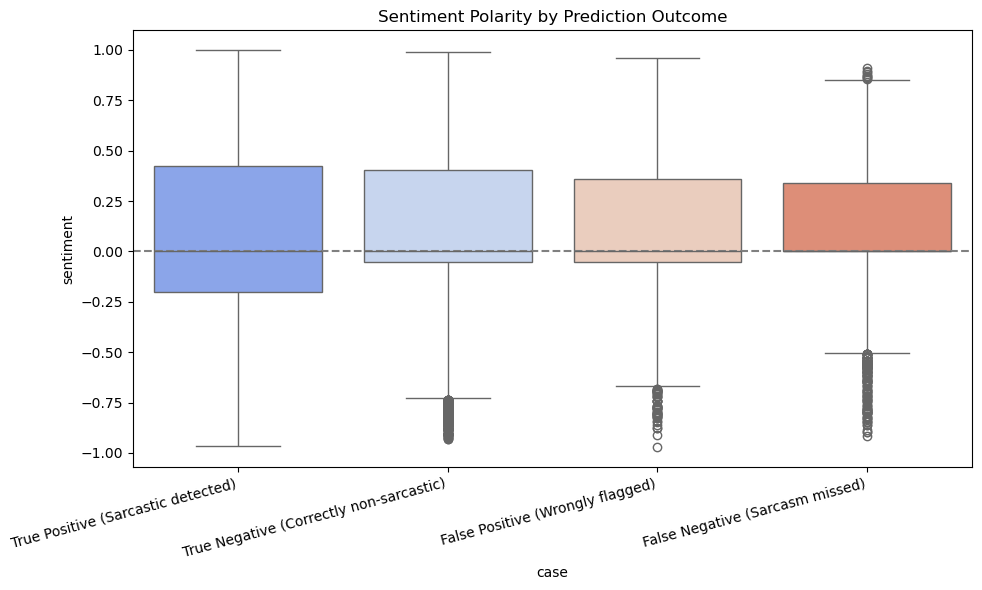


📊 Sentiment Summary by Case:
                                             mean       std  count
case                                                              
False Negative (Sarcasm missed)          0.055467  0.364027   1744
False Positive (Wrongly flagged)         0.071224  0.383982   1416
True Negative (Correctly non-sarcastic)  0.074631  0.412107   8680
True Positive (Sarcastic detected)       0.076466  0.435769  10425

==== True Positive (Sarcastic detected) (showing 5 examples) ====
• <USER> If I didn't, who the fuck would...?

• 8th grader impregnated during trip to 'march for life' event

• <USER> very true. Gosh I just can't wait! sarcastic

• bullshit, you blackmail leadership with all those embarrassing or incriminating photos you 'choose' not to publish

• b-b-but mockingbird was ended


==== False Negative (Sarcasm missed) (showing 5 examples) ====
• kendrick lamar deletes 'rhymezone.com' from internet history

• Just use the hot tub to defrost it.

• Was she in eatin

In [ ]:
# Make predictions

preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=-1)
texts = test_df["text"].tolist()

# Sentiment Error Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

analyzer = SentimentIntensityAnalyzer()

# Build analysis DataFrame
import pandas as pd
data = pd.DataFrame({
    "text": texts,
    "true": y_true,
    "pred": y_pred
})

def label_case(row):
    if row.true == 1 and row.pred == 1:
        return "True Positive (Sarcastic detected)"
    elif row.true == 1 and row.pred == 0:
        return "False Negative (Sarcasm missed)"
    elif row.true == 0 and row.pred == 1:
        return "False Positive (Wrongly flagged)"
    else:
        return "True Negative (Correctly non-sarcastic)"

data["case"] = data.apply(label_case, axis=1)
data["sentiment"] = data["text"].apply(lambda x: analyzer.polarity_scores(str(x))["compound"])

# Plot distributions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.boxplot(x="case", y="sentiment", data=data, palette="coolwarm")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Sentiment Polarity by Prediction Outcome")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

# Summary
summary = data.groupby("case")["sentiment"].agg(["mean", "std", "count"])
print("\nSentiment Summary by Case:")
print(summary)

# Show representative examples
def show_examples(case, n=5):
    subset = data[data["case"] == case].sample(min(n, len(data[data["case"] == case])))
    print(f"\n==== {case} (showing {len(subset)} examples) ====")
    for t in subset["text"]:
        print("•", t)
        print()

show_examples("True Positive (Sarcastic detected)")
show_examples("False Negative (Sarcasm missed)")

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                    mean       std  count
case                                     
True Positive   0.965725  0.078740  10425
True Negative   0.948608  0.087059   8680
False Negative  0.850155  0.119107   1744
False Positive  0.840252  0.129355   1416


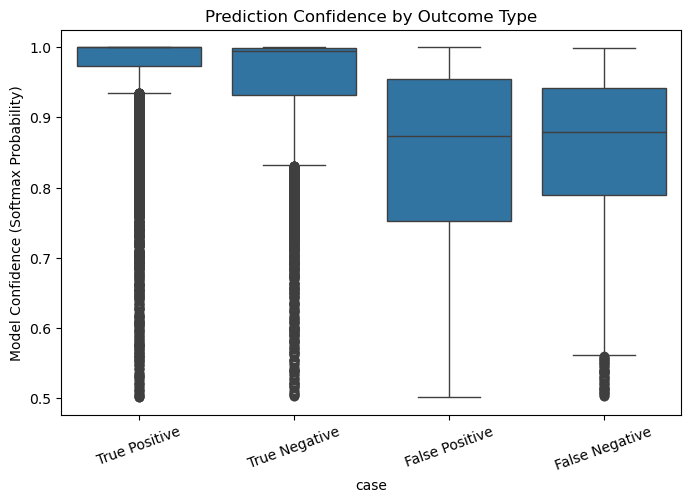

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have your trained model and test dataset (test_ds)
preds = trainer.predict(test_ds)

# logits = raw model outputs (shape: [num_samples, num_classes])
logits = preds.predictions

# Convert to probabilities using softmax
import torch
import numpy as np

y_prob = torch.softmax(torch.tensor(logits), dim=1).numpy()

# Predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# True labels
y_true = preds.label_ids

# Compute confidence
confidences = y_prob.max(axis=1)

# Derive case type (TP, TN, FP, FN)
cases = []
for t, p in zip(y_true, y_pred):
    if t == 1 and p == 1:
        cases.append("True Positive")
    elif t == 0 and p == 0:
        cases.append("True Negative")
    elif t == 0 and p == 1:
        cases.append("False Positive")
    elif t == 1 and p == 0:
        cases.append("False Negative")

# Create DataFrame
df_conf = pd.DataFrame({
    "true_label": y_true,
    "pred_label": y_pred,
    "confidence": confidences,
    "case": cases
})

# Summary statistics
summary = df_conf.groupby("case")["confidence"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False)
print(summary)

# visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=df_conf, x="case", y="confidence", order=["True Positive","True Negative","False Positive","False Negative"])
plt.title("Prediction Confidence by Outcome Type")
plt.ylabel("Model Confidence (Softmax Probability)")
plt.xticks(rotation=20)
plt.show()
